In [ ]:
from numpy.random import seed
from tensorflow.random import set_seed

import keras
import io
print(keras.__version__)
import tensorflow
print(tensorflow.__version__)
import pandas_datareader
import time
#import talib
import requests
import pandas as pd
import requests
import pandas_datareader.data as web
import numpy as np
from keras.layers import Flatten, Conv2D, Input, Conv1D, LeakyReLU, PReLU
from datetime import timedelta
from datetime import datetime
import numpy as np

from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Bidirectional, RepeatVector, TimeDistributed
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.layers import LSTM

import matplotlib.pyplot as plt

from datetime import datetime

## 1. Classes/Functions used for NAS:

### 1.1. Class for RNN Cell (custom Layer) constructed as a Tree:

- The implementation follows the one of LSTM-s (https://github.com/keras-team/keras/blob/master/keras/layers/recurrent.py)

- **The Init-Method**: initialized all relevant attributes in the class

- **The Build-Method**: initializes the weights for the current state, hidden state and the biases

- **The Call-Method**: 
        - computes the output of each node in the RNN-Tree-Cell
        - returns the output of the final node as the new hidden state
        - as well as: the new cell state based on a pre-specified index (set in the Init-Method)

In [ ]:
#ACCORDING TO PAPER: https://arxiv.org/pdf/1611.01578.pdf
## import tensorflow as tf
import numpy as np

import keras

from keras import backend as K
#tf.keras.backend.clear_session()
import sys
import traceback
from keras.layers import RNN
from keras.models import Model
from keras import activations, initializers,regularizers, constraints
import tensorflow as tf

class Custom_RNNCell_tree(keras.layers.Layer):
    def __init__(self, units,
                 base,
                 #Leaf Nodes:
                 activations_leaf_nodes,
                 actions_leaf_nodes,
                 #Cell Inject:
                 index_cell_inject,
                 action_cell_inject,
                 activation_cell_inject,
                 #New Cell State:
                 index_new_cell_state,
                 #Intermediate Levels (Internal Nodes):
                 index_intermediate_levels,
                 activations_intermediate_levels,
                 actions_intermediate_levels,
                 #Final Node:
                 index_last_node,
                 activation_last_node,
                 action_last_node,
                 #Biases Condition:
                 use_bias=True,
                 #Initializers:
                 kernel_initializer='glorot_uniform',
                 recurrent_initializer='orthogonal',
                 bias_initializer='zeros',
                 #Regularizers:
                 kernel_regularizer=None,
                 recurrent_regularizer=None,
                 bias_regularizer=None,
                 #Constant Constraints:
                 kernel_constraint=None,
                 recurrent_constraint=None,
                 bias_constraint=None,
                 #Dropout Constraints:
                 dropout=0.,
                 recurrent_dropout=0,**kwargs):
        
        self.units = units
        self.state_size =(self.units, self.units)
        self.output_size = self.units
        self.base=base
        
        #Leaf Nodes:
        self.activations_leaf_nodes=activations_leaf_nodes
        self.actions_leaf_nodes=actions_leaf_nodes
        
        #Cell Inject:
        self.index_cell_inject=index_cell_inject
        self.action_cell_inject=action_cell_inject
        self.activation_cell_inject=activation_cell_inject
        
        #New Cell State:
        self.index_new_cell_state=index_new_cell_state
        
        #Intermediate Nodes:
        self.index_intermediate_levels=index_intermediate_levels
        self.activations_intermediate_levels=activations_intermediate_levels
        self.actions_intermediate_levels=actions_intermediate_levels
        
        #Final Node:
        self.index_last_node=index_last_node
        self.activation_last_node=activation_last_node
        self.action_last_node=action_last_node
        
        #Biases:
        self.use_bias = use_bias

        #Weights Initializer:
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.recurrent_initializer = initializers.get(recurrent_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        
        #Weights Regularizer:
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.recurrent_regularizer = regularizers.get(recurrent_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        
        #Weights Constant Constraints:
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.recurrent_constraint = constraints.get(recurrent_constraint)
        self.bias_constraint = constraints.get(bias_constraint)

        #Dropout Constraints:
        self.dropout = min(1., max(0., dropout))
        self.recurrent_dropout = min(1., max(0., recurrent_dropout))
        
        self._dropout_mask = None
        self._recurrent_dropout_mask = None
        super(Custom_RNNCell_tree, self).__init__(**kwargs)
        
        
    def build(self, input_shape):
        
        #1. INPUTS:#############################################################################
        #1.1. KERNEL INPUTS/ WEIGHTS FOR INPUTS:
        self.kernel_current_input = self.add_weight(shape=(input_shape[-1], self.units*self.base),
                                              initializer=self.kernel_initializer,#"glorot_uniform",#'uniform',
                                              regularizer=self.kernel_regularizer,
                                              name='kernel')
        #print("Initialized Weights First Node (For Inputs): ")
        #print(K.eval(self.kernel_current_input))
        
        #1.2. BIAS WEIGHTS FOR INPUTS:
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.units*self.base,),
                                        name='bias_inputs',
                                        initializer=self.bias_initializer,
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        #########################################################################################
        
        #2. RECURRENT STATE: ####################################################################
        #2.1. RECURRENT KERNEL / WEIGHTS FOR PREVIOUS HIDDEN STATE:
        self.kernel_previous_hidden = self.add_weight(
                    shape=(self.units, self.units*self.base),
                    initializer=self.recurrent_initializer,#"glorot_uniform",#'uniform',
                    regularizer=self.recurrent_regularizer,
                    name='recurrent_kernel')
        #print("Initialized Weights Recurrent Sate:")
        #print(K.eval(self.kernel_previous_hidden))
        ########################################################################################
        
        #kernel_list=[]
        
        #Input Weights for each of the leaf nodes: 
        self.kernel_0 = self.kernel_current_input[:, :self.units]
        self.kernel_1 = self.kernel_current_input[:, self.units: self.units * 2]
        self.kernel_2 = self.kernel_current_input[:, self.units * 2: self.units * 3]
        self.kernel_3 = self.kernel_current_input[:, self.units * 3: self.units * 4]
        self.kernel_4 = self.kernel_current_input[:, self.units * 4: self.units * 5]
        self.kernel_5 = self.kernel_current_input[:, self.units * 5: self.units * 6]
        self.kernel_6 = self.kernel_current_input[:, self.units * 6: self.units * 7]
        self.kernel_7 = self.kernel_current_input[:, self.units * 7:]
        
        #recurrent_kernel_list=[]
        
        #Recurrent Weights for each of the leaf nodes: 
        self.recurrent_kernel_0 = self.kernel_previous_hidden[:, :self.units]
        self.recurrent_kernel_1 = self.kernel_previous_hidden[:, self.units: self.units * 2]
        self.recurrent_kernel_2 = self.kernel_previous_hidden[:, self.units * 2: self.units * 3]
        self.recurrent_kernel_3 = self.kernel_previous_hidden[:, self.units * 3: self.units * 4]
        self.recurrent_kernel_4 = self.kernel_previous_hidden[:, self.units * 4: self.units * 5]
        self.recurrent_kernel_5 = self.kernel_previous_hidden[:, self.units * 5: self.units * 6]
        self.recurrent_kernel_6 = self.kernel_previous_hidden[:, self.units * 6: self.units * 7]
        self.recurrent_kernel_7 = self.kernel_previous_hidden[:, self.units * 7:]
        
        #if self.use_bias:
        #     bias_list=[]
        
        #Biases:
        if self.use_bias:
            self.bias_0 = self.bias[:self.units]
            self.bias_1 = self.bias[self.units: self.units * 2]
            self.bias_2 = self.bias[self.units * 2: self.units * 3]
            self.bias_3 = self.bias[self.units * 3: self.units * 4]
            self.bias_4 = self.bias[self.units * 4: self.units * 5]
            self.bias_5 = self.bias[self.units * 5: self.units * 6]
            self.bias_6 = self.bias[self.units * 6: self.units * 7]
            self.bias_7 = self.bias[self.units * 7: ]
        else:
            self.bias_0 = None
            self.bias_1 = None
            self.bias_2 = None
            self.bias_3 = None
            self.bias_4 = None
            self.bias_5 = None
            self.bias_6 = None
            self.bias_7 = None
            
        
           
        #self.built = True
        super(Custom_RNNCell_tree, self).build(input_shape)
        
        
    def call(self, inputs, states, training=None):
        #GET THE STATES:
        prev_output = states[0]
        prev_cell_state=states[1]
        
        #START LEAF NODES: ##################################################################################
        if 0 < self.dropout < 1 and self._dropout_mask is None:
            self._dropout_mask = _generate_dropout_mask(
                K.ones_like(inputs),
                self.dropout,
                training=training,
                count=self.base)
            
        if (0 < self.recurrent_dropout < 1 and
                self._recurrent_dropout_mask is None):
            self._recurrent_dropout_mask = _generate_dropout_mask(
                K.ones_like(prev_output),
                self.recurrent_dropout,
                training=training,
                count=self.base)
        

        dp_mask = self._dropout_mask
        rec_dp_mask = self._recurrent_dropout_mask
        
        
        #INPUTS:
        if 0 < self.dropout < 1.:
                inputs_0 = inputs * dp_mask[0]
                inputs_1 = inputs * dp_mask[1]
                inputs_2 = inputs * dp_mask[2]
                inputs_3 = inputs * dp_mask[3]
                inputs_4 = inputs * dp_mask[4]
                inputs_5 = inputs * dp_mask[5]
                inputs_6 = inputs * dp_mask[6]
                inputs_7 = inputs * dp_mask[7]
        else:
                inputs_0 = inputs 
                inputs_1 = inputs
                inputs_2 = inputs 
                inputs_3 = inputs 
                inputs_4 = inputs 
                inputs_5 = inputs 
                inputs_6 = inputs
                inputs_7 = inputs 
        #WEIGHTS MATRIX MULTIPLICATION INPUTS:
        mm_iputs_0 = K.dot(inputs_0, self.kernel_0)
        mm_iputs_1 = K.dot(inputs_1, self.kernel_1)
        mm_iputs_2 = K.dot(inputs_2, self.kernel_2)
        mm_iputs_3 = K.dot(inputs_3, self.kernel_3)
        mm_iputs_4 = K.dot(inputs_4, self.kernel_4)
        mm_iputs_5 = K.dot(inputs_5, self.kernel_5)
        mm_iputs_6 = K.dot(inputs_6, self.kernel_6)
        mm_iputs_7 = K.dot(inputs_7, self.kernel_7)
        
        
        
        #ADDING BIAS TO MM INPUTS:
        if self.use_bias:
                mm_iputs_0 = K.bias_add(mm_iputs_0, self.bias_0)
                mm_iputs_1 = K.bias_add(mm_iputs_1, self.bias_1)
                mm_iputs_2 = K.bias_add(mm_iputs_2, self.bias_2)
                mm_iputs_3 = K.bias_add(mm_iputs_3, self.bias_3)
                mm_iputs_4 = K.bias_add(mm_iputs_4, self.bias_4)
                mm_iputs_5 = K.bias_add(mm_iputs_5, self.bias_5)
                mm_iputs_6 = K.bias_add(mm_iputs_6, self.bias_6)
                mm_iputs_7 = K.bias_add(mm_iputs_7, self.bias_7)
        
        #SAVE OUTPUT FROM WEIGHTS-MM INPUTS IN A LIST:
        mm_inputs_array=[mm_iputs_0,mm_iputs_1,mm_iputs_2,
                        mm_iputs_3,mm_iputs_4,mm_iputs_5,
                        mm_iputs_6,mm_iputs_7]
                
        #HIDDEN STATE:
        if 0 < self.recurrent_dropout < 1.:
                prev_output_0 = prev_output * rec_dp_mask[0]
                prev_output_1 = prev_output * rec_dp_mask[1]
                prev_output_2 = prev_output * rec_dp_mask[2]
                prev_output_3 = prev_output * rec_dp_mask[3]
                prev_output_4 = prev_output * rec_dp_mask[4]
                prev_output_5 = prev_output * rec_dp_mask[5]
                prev_output_6 = prev_output * rec_dp_mask[6]
                prev_output_7 = prev_output * rec_dp_mask[7]
        else:
            prev_output_0 = prev_output
            prev_output_1 = prev_output 
            prev_output_2 = prev_output 
            prev_output_3 = prev_output 
            prev_output_4 = prev_output 
            prev_output_5 = prev_output 
            prev_output_6 = prev_output 
            prev_output_7 = prev_output
            
        #WEIGHTS MATRIX MULTIPLICATION HIDDEN STATE:
        mm_previous_output_0=K.dot(prev_output_0, self.recurrent_kernel_0)
        mm_previous_output_1=K.dot(prev_output_1, self.recurrent_kernel_1)
        mm_previous_output_2=K.dot(prev_output_2, self.recurrent_kernel_2)
        mm_previous_output_3=K.dot(prev_output_3, self.recurrent_kernel_3)
        mm_previous_output_4=K.dot(prev_output_4, self.recurrent_kernel_4)
        mm_previous_output_5=K.dot(prev_output_5, self.recurrent_kernel_5)
        mm_previous_output_6=K.dot(prev_output_6, self.recurrent_kernel_6)
        mm_previous_output_7=K.dot(prev_output_7, self.recurrent_kernel_7)
        
        #SAVE OUTPUT FROM WEIGHTS-MM HIDDEN STATE IN A LIST:
        mm_previous_output_array=[mm_previous_output_0,mm_previous_output_1,mm_previous_output_2,
                                 mm_previous_output_3,mm_previous_output_4,mm_previous_output_5,
                                 mm_previous_output_6,mm_previous_output_7]
        
        outputs_before_activation=[]
        outputs_after_activation=[]
        #OUTPUTS LEAF NODES:
        for i in range(0,len(mm_inputs_array)):
            if self.actions_leaf_nodes[i]=="add":
                output_before_activation=mm_inputs_array[i]+mm_previous_output_array[i]
            else:
                output_before_activation=mm_inputs_array[i]*mm_previous_output_array[i]
            outputs_before_activation.append(output_before_activation)
            
            output_after_activation=activations.get(self.activations_leaf_nodes[i])(output_before_activation)
            outputs_after_activation.append(output_after_activation)
            
            #CHECK IF INDEX_CELL_INJECT WITHIN ALREADY ADDED OUTPUTS FROM LEAF NODES:
            check_index_leafs=len(outputs_after_activation)-1
            if self.index_cell_inject==check_index_leafs:
                relevant_output=outputs_after_activation[check_index_leafs]
                if self.action_cell_inject=="add":
                    output_cell_inject_before_activation=relevant_output+prev_cell_state
                else:
                    output_cell_inject_before_activation=relevant_output*prev_cell_state
                
                #Overwrite outputs before activation:
                outputs_before_activation[check_index_leafs]=output_cell_inject_before_activation
                
                output_cell_inject_after_activation=activations.get(self.activation_cell_inject)(output_cell_inject_before_activation)
                #Overwrite the saved output in the list outputs_after_activation:
                outputs_after_activation[check_index_leafs]=output_cell_inject_after_activation
                
        #DONE WITH LEAF NODES##################################################################################
        
        
        #START INTERMEDIATE LEVEL NODES: INTERNAL NODES:#############################################################
        for i in range(0,len(self.index_intermediate_levels)):
            #Get each pair of indexes:
            indexes_intermediate_level=self.index_intermediate_levels[i]
            #Split the pair in first and second part indexes:
            indexes_first=indexes_intermediate_level[0]
            indexes_second=indexes_intermediate_level[1]
            #Get the corresponding outputs from the list with outputs after applying the activation:
            output_first_part=outputs_after_activation[indexes_first]
            output_second_part=outputs_after_activation[indexes_second]
            
            #Perform the corresponding action: add or elemwise multiplication:
            if self.actions_intermediate_levels[i]=="add":
                output_intermediate_before_activation=output_first_part+output_second_part
            else:
                output_intermediate_before_activation=output_first_part*output_second_part
            
            #Append the output before applying the activation function:
            outputs_before_activation.append(output_intermediate_before_activation)
            
            #Apply the activation function and save the output in the corresponding list:
            output_intermediate_after_activation=activations.get(self.activations_intermediate_levels[i])(output_intermediate_before_activation)
            outputs_after_activation.append(output_intermediate_after_activation)
            
            #CHECK IF INDEX_CELL_INJECT WITHIN ALREADY ADDED OUTPUTS FROM LEAF NODES:
            check_index_intermediate=len(outputs_after_activation)-1
            if self.index_cell_inject==check_index_intermediate:
                #(redundant code:)
                relevant_output=outputs_after_activation[check_index_intermediate]
                if self.action_cell_inject=="add":
                    output_cell_inject_before_activation=relevant_output+prev_cell_state
                else:
                    output_cell_inject_before_activation=relevant_output*prev_cell_state
                
                #Overwrite Outputs before Activation:
                outputs_before_activation[check_index_intermediate]=output_cell_inject_before_activation
                
                output_cell_inject_after_activation=activations.get(self.activation_cell_inject)(output_cell_inject_before_activation)
                #Overwrite the saved output in the list outputs_after_activation:
                outputs_after_activation[check_index_intermediate]=output_cell_inject_after_activation
        #DONE WITH INTERMEDIATE LEVEL NODES: ###############################################################
        
        
        #START FINAL NODE: #################################################################################
        #Get last and pre-last index from array with outputs after activations:
        last_index=len(outputs_after_activation)-1
        pre_last_index=len(outputs_after_activation)-2
        #Get the corresponding outputs:
        last_output=outputs_after_activation[last_index]
        pre_last_output=outputs_after_activation[pre_last_index]
        
        #Perform the final action:
        if self.action_last_node=="add":
            output_final_before_activation=last_output+pre_last_output
        else:
            output_final_before_activation=last_output*pre_last_output
        
        #Append the final output before activation:
        outputs_before_activation.append(output_final_before_activation)
        
        #Apply activation and save the final output in the corresponding list:
        output_final_after_activation=activations.get(self.activation_last_node)(output_final_before_activation)
        outputs_after_activation.append(output_final_after_activation)
        
        ##CHECK IF INDEX_CELL_INJECT EQUAL TO FINAL NODE INDEX:
        check_index_last=len(outputs_after_activation)-1
        if self.index_cell_inject==check_index_last:
            relevant_output=outputs_after_activation[check_index_last]
            if self.action_cell_inject=="add":
                output_cell_inject_before_activation=relevant_output+prev_cell_state
            else:
                output_cell_inject_before_activation=relevant_output*prev_cell_state
            
            #Overwrite Outputs before activation:
            outputs_before_activation[check_index_last]=output_cell_inject_before_activation
            
            
            output_cell_inject_after_activation=activations.get(self.activation_cell_inject)(output_cell_inject_before_activation)
            #Overwrite the saved output in the list outputs_after_activation:
            outputs_after_activation[check_index_last]=output_cell_inject_after_activation
        #DONE WITH FINAL NODE: ##############################################################################
         
        #Get the new cell state:
        new_cell_state=outputs_before_activation[self.index_new_cell_state]
        
        #Get new hidden state: final output:
        new_hidden_state=outputs_after_activation[len(outputs_after_activation)-1]
        
        
        # Properly set learning phase on output tensor.
        if 0 < self.dropout + self.recurrent_dropout:
            if training is None:
                new_hidden_state._uses_learning_phase = True
        return new_hidden_state,[new_hidden_state,new_cell_state]
        
def _generate_dropout_mask(ones, rate, training=None, count=1):
    def dropped_inputs():
        return K.dropout(ones, rate)

    if count > 1:
        return [K.in_train_phase(
            dropped_inputs,
            ones,
            training=training) for _ in range(count)]
    return K.in_train_phase(
        dropped_inputs,
        ones,
        training=training)

### 1.2. Objective Functions for Sampling Hyperparameters with Optuna:

### 1.2.1. Objective Function for RNN-Cell structured as a Tree:
- **Samples the Architecture of the RNN-Cell in the following way**:
        - for each of the 8 leaf nodes in the RNN-Cell: 
          samples an action for the current & hidden state (addition or elemntwise multiplication)
          and an activation function from {tanh, relu, sigmoid, linear} which is applied after the 
          action is performed 
          
        - for the intermediate nodes: 
          samples a combination of the indexes of the nodes from the previous level,
          an action & an activation function
          
        - for injecting the previous cell state:
          samples an index in the tree, an action and an activation function
          
        - for the new cell state:
          samples an index in the tree
- **Samples further Hyperparameters relevant for the Performance of the RNN**:
        - number of neurons for each of the custom RNN layers (2 layers used)
        
        - dropout rate  for a Dropout-Layer after each of the custom RNN layers
        
        - weights regularization: type and decay
        
        - epochs
        
        - batch size
        
        - window-size: the number of timesteps in each sequence
        
        - learning rate

In [ ]:
import optuna
### import extra_keras_metrics
def objective_RNN_Tree(trial):  
    seed(123)
    set_seed(123)
    
    print("SUMMARY CURRENT TRIAL: "+"\n")
    
    print("1. CUSTOM RNN-CELL HYPERPARAMETERS:"+"\n")
    n_base=8
    #1. FIRST LEVEL: LEAF NODES WITH INDEX (BOTTOM-UP) ################################################
    activations=[]
    actions=[]
    
    for i in range(0,n_base):
        activation=trial.suggest_categorical('activation_tree_index_{}'.format(i), 
                                             ["relu","tanh","sigmoid","linear"])
        action=trial.suggest_categorical('action_tree_index_{}'.format(i), ["add","elem_multi"])
        activations.append(activation)
        actions.append(action)
    ####################################################################################################
    
    
    
    #2. SECOND LEVEL: ##################################################################################
    #2.1. CHOOSE HOW MANY TIMES TO SAMPLE:
    keep_sampling=True
    
    indexes_to_sample=list(range(n_base))
    all_indexes_tree=list(range(n_base))
    print("  - Sample Index Combinations from: ",indexes_to_sample)
    
    track_excluded="excludeFromNodes_"
        
    while keep_sampling:
        #Start with the first available index in remaining list indexes_to_sample:
        first_index=indexes_to_sample[0]
        print("  - First Index: ",first_index)
        indexes_to_sample.remove(first_index)
        track_excluded=track_excluded.split("_")[0]
        track_excluded=track_excluded+"_"+str(indexes_to_sample)
        
        second_index=trial.suggest_categorical(track_excluded, indexes_to_sample)
        print("  - Second Index: ",second_index)
        indexes_to_sample.remove(second_index)
        all_indexes_tree.append([first_index,second_index])
        activation=trial.suggest_categorical('activation_tree_index_{}'.format(len(all_indexes_tree)-1), ["relu","tanh","sigmoid","linear"])
        action=trial.suggest_categorical('action_tree_index_{}'.format(len(all_indexes_tree)-1), ["add","elem_multi"])
        activations.append(activation)
        actions.append(action)
        print("  - Remaining Indexes in list: ",indexes_to_sample)
        print("  - All Indexes so far: ",all_indexes_tree)
        print("")
        
        if len(indexes_to_sample)<=2:
            if len(indexes_to_sample)>0:
                all_indexes_tree.append(indexes_to_sample)
                activation=trial.suggest_categorical('activation_tree_index_{}'.format(len(all_indexes_tree)-1), ["relu","tanh","sigmoid","linear"])
                action=trial.suggest_categorical('action_tree_index_{}'.format(len(all_indexes_tree)-1), ["add","elem_multi"])
                activations.append(activation)
                actions.append(action)
            else:
                print("Array with Indexes empy!")
            print("  - All Indexes so far: ",all_indexes_tree)
            print("")
            keep_sampling=False   
    ####################################################################################################
    
    
    #THIRD & FOURTH LEVEL: ###############################################################
    #Chose combination for third level tree indexes/ second level internal nodes:
    indexes_internal_nodes=list(range(len(all_indexes_tree)))[n_base:]
    
    #THIRD LEVEL:
    first_index=indexes_internal_nodes[0]
    print("  - First Index: ",first_index)
    indexes_internal_nodes.remove(first_index)
    second_index=trial.suggest_categorical("excludeFromNodes_"+str(indexes_internal_nodes), indexes_internal_nodes)
    print("  - Second Index: ",second_index)
            
    indexes_internal_nodes.remove(second_index)        
    all_indexes_tree.append([first_index,second_index])
    activation=trial.suggest_categorical('activation_tree_index_'+str(len(all_indexes_tree)-1),
                                             ["relu","tanh","sigmoid","linear"])
    action=trial.suggest_categorical('action_tree_index_'+str(len(all_indexes_tree)-1),
                                         ["add","elem_multi"])
    activations.append(activation)
    actions.append(action)

    all_indexes_tree.append(indexes_internal_nodes)
    activation=trial.suggest_categorical('activation_tree_index_'+str(len(all_indexes_tree)-1),
                                             ["relu","tanh","sigmoid","linear"])
    action=trial.suggest_categorical('action_tree_index_'+str(len(all_indexes_tree)-1),
                                         ["add","elem_multi"])
    activations.append(activation)
    actions.append(action)
    print("  - Remaining Indexes in internal Nodes: ",indexes_internal_nodes)
    print("  - All Indexes so far: ",all_indexes_tree)
            
    print("")

    #FOURTH/FINAL LEVEL:
    fourth_level_first_index=len(all_indexes_tree)-1
    fourth_level_second_index=len(all_indexes_tree)-2
    all_indexes_tree.append([fourth_level_first_index,fourth_level_second_index])
        
    activation=trial.suggest_categorical('activation_tree_index_'+str(len(all_indexes_tree)-1),
                                             ["relu","tanh","sigmoid","linear"])
    action=trial.suggest_categorical('action_tree_index_'+str(len(all_indexes_tree)-1),
                                         ["add","elem_multi"])
    activations.append(activation)
    actions.append(action)
    print("  - First Index: ",fourth_level_first_index)
    print("  - Second Index: ",fourth_level_second_index)
    print("  - All Indexes so far: ",all_indexes_tree)
    print("")
    
    print("  - All Indexes so far: ",all_indexes_tree)
    print("")
    ####################################################################################################
     
        
    #SPLIT THE ACTIVATIONS, ACTIONS AND INDEXES IN LEAF, INTERMEDIATE & FINAL LEVEL: ###################
    leaf_level_activations=activations[0:n_base]
    leaf_level_actions=actions[0:n_base]
    leaf_level_indexes=all_indexes_tree[0:n_base]
    print("  1.1. First Level / Leaf Nodes:")
    print("     - Activations: ",leaf_level_activations)
    print("     - Actions: ",leaf_level_actions)
    print("     - Indexes: ",leaf_level_indexes)
    print("")
    
    intermediate_level_activations=activations[n_base:-1]
    intermediate_level_actions=actions[n_base:-1]
    intermediate_level_indexes=all_indexes_tree[n_base:-1]
    print("  1.2. Intermediate Nodes: ")
    print("     - Activations: ",intermediate_level_activations)
    print("     - Actions: ",intermediate_level_actions)
    print("     - Indexes: ",intermediate_level_indexes)
    print("")
    
    final_level_activation=activations[-1]
    final_level_action=actions[-1]
    final_level_indexes=all_indexes_tree[-1]
    print("  1.3. Final Node: ")
    print("     - Activations: ",final_level_activation)
    print("     - Actions: ",final_level_action)
    print("     - Indexes: ",final_level_indexes)
    print("")
    ####################################################################################################
    
    
    #SAMPLE HYPERPARAMETER FOR THE CELL INJECT AND NEW CELL STATE: #####################################
    cell_inject_new_state=list(range(len(all_indexes_tree)))
    print("  1.4. Cell Inject & new Cell State: ")
    print("     - Sample new Cell State Index & Cell Inject Index from: ",cell_inject_new_state)
    index_new_cell_state=trial.suggest_categorical('index_new_cell_state', cell_inject_new_state)
    index_cell_inject=trial.suggest_categorical('index_cell_inject', cell_inject_new_state)
    activation_cell_inject=trial.suggest_categorical('activation_cell_inject', ["relu","tanh","sigmoid","linear"])
    action_cell_inject=trial.suggest_categorical('action_cell_inject', ["add","elem_multi"])
    print("     - Index new Cell State: ",index_new_cell_state)
    print("     - Index Cell Inject: ",index_cell_inject)
    print("     - Activation Cell Inject: ",activation_cell_inject)
    print("     - Action Cell Inject: ",action_cell_inject+"\n")
    ####################################################################################################
    
    
    #SAMPLE FURTHER HYPERPARAMETERS: ###################################################################
    
    
    dropout_1=trial.suggest_categorical('dropout_1', [0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5])
    dropout_2=trial.suggest_categorical('dropout_2', [0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5])
    
    neurons_1=trial.suggest_int('neurons_1', low=100, high=800, step=50)
    neurons_2=trial.suggest_int('neurons_2', low=100, high=800, step=50)
    #use_regularizer=trial.suggest_categorical('use_regularizer', [True,False])
    
    type_weights_regularizer=trial.suggest_categorical('type_regularizer', ["L1","L2"])
    rl_value=trial.suggest_categorical('rl_value', 
                                           [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
                                           0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09,0.1])
    
    
    epochs=trial.suggest_categorical('epochs', [100,150,200])
    
    batch_size=trial.suggest_categorical('batch_size', [32,64,128])
    
    window_size=trial.suggest_int('window_size', low=5, high=50, step=1)
    
    
    lr_value=trial.suggest_discrete_uniform('lr_value', 0.001,0.01,0.001)
    lr_value=round(lr_value,5)
    #clipvalue=trial.suggest_categorical('clipvalue',[1.0,1.5,2.0])#,1.0,1.5,2.0])
    ####################################################################################################
    
    #Currently fix hyperparameters:
    num_layers=2#fixed!
    train_test_split=0.7#trial.suggest_categorical('train_test_split', [0.7,0.75,0.8])
    
    optimizer="adam"#trial.suggest_categorical('optimizer', ["adam","Adagrad"])
    
    callbacks_patience=10#trial.suggest_categorical('callbacks_patience', [10,15])
    early_stop=EarlyStopping(monitor='val_loss', mode='min',min_delta=0.01, 
                             verbose=0, patience=callbacks_patience, 
                             restore_best_weights=True)
    callbacks=[early_stop]
    
    
    #PRINT OUT SUMMARY OF SAMPLED HYPERPARAMETERS TO KEEP TRACK OF THE OPTIMIZATION: ###################
    print("2. FURTHER HYPERPARAMETERS:"+"\n")
    print("  2.1. UNCONDITIONAL:"+"\n")
    print("     - Window Size Sequences: "+str(window_size))
    print("     - Sequential Split: first "+str(train_test_split*100)+"% train set, the rest "+str(round((1-train_test_split),2)*100)+"% test set")
    print("     - Number Layers: "+str(num_layers))
    print("     - Number Neurons 1. Layer: "+str(neurons_1))
    print("     - Number Neurons 2. Layer: "+str(neurons_2))
    
    #print("  - Activation Function: "+activation)
    print("     - Dropout after 1. Layer: "+str(dropout_1))
    print("     - Dropout before final Dense Layer: "+str(dropout_2))
    print("     - Batch Size: "+str(batch_size))
    print("     - Epochs: "+str(epochs))
    print("     - Callbacks (Patience): "+str(callbacks_patience))
    print("     - Optimizer: "+optimizer)
    print("     - Learning Rate Value: "+str(lr_value))
    print("     - Type Regularization: "+type_weights_regularizer)
    print("     - Decay for Regularization: "+str(rl_value)+"\n")   
    
    #print("     - Clip-Norm: "+str(clipvalue))
    
    
     
    ###################################################################################################        
    #DATA PREPROCESSING: ###############################################################################
    relevant_data=synthetic_time_series_combined_kernel.copy()#synthetic_data[0].copy()
    X_sequences, y_sequences=split_sequence_univariate(relevant_data.values, window_size)
    X_sequences=X_sequences.reshape(X_sequences.shape[0],X_sequences.shape[1],1)
    y_sequences=y_sequences.reshape(y_sequences.shape[0],1)
    train_size=train_size=int(train_test_split*len(X_sequences))
    X_train, X_test =X_sequences[:train_size],X_sequences[train_size:]
    y_train,y_test=y_sequences[:train_size],y_sequences[train_size:]
    ####################################################################################################
    
    
    #BUILD AND TRAIN THE RNN-MODEL WITH THE SAMPLED HYPERPARAMETERS (CUSTOM-RNN-CELL): #################
    
    #USE WHEN TESTING CUSTOM RNN CELL: #############################################################
    model=build_custom_model(type_weights_regularizer,rl_value,
                      X_train,n_base,neurons_1,neurons_2,dropout_1,dropout_2,
                      optimizer,lr_value,
                      leaf_level_activations,leaf_level_actions,
                      index_cell_inject,action_cell_inject,activation_cell_inject,
                      index_new_cell_state,
                      intermediate_level_indexes,intermediate_level_activations,intermediate_level_actions,
                      final_level_indexes,final_level_activation,final_level_action,clip_gradients=False,
                      clipvalue=None)
    ####################################################################################################
    
    print("3. KERAS ARCHITECTURE SUMMARY:")
    print(model.summary())
    
    #TRY FITTING THE SAMPLED RNN-MODEL:
    try:
        history_fitted_model=model.fit(X_train, y_train, 
                                   epochs=epochs, batch_size=batch_size, 
                                   validation_data=[X_test,y_test],verbose=1,
                                   callbacks=callbacks)
        output="no_nans"
    except TypeError:
        #IF THE ERROR OCCURS: THE MODEL PRODUCED NANS, REPLACING THE FINAL ACTIVATION LAYER
        #WITH ONE THAT SQUASHES THE VALUES FOR THE NEW HIDDEN STATE MORE: TANH OR SIGMOID
        print("     - The model produced nans, changing final Activation Function: ")   
        change_final_activation=trial.suggest_categorical("change_final_activation",["tanh","sigmoid"])
        final_level_activation=change_final_activation
        print("     - New Final Activation Function: "+final_level_activation+"\n")   
        model=build_custom_model(type_weights_regularizer,rl_value,
                      X_train,n_base,neurons_1,neurons_2,dropout_1,dropout_2,
                      optimizer,lr_value,
                      leaf_level_activations,leaf_level_actions,
                      index_cell_inject,action_cell_inject,activation_cell_inject,
                      index_new_cell_state,
                      intermediate_level_indexes,intermediate_level_activations,intermediate_level_actions,
                      final_level_indexes,final_level_activation,final_level_action,clip_gradients=False,
                      clipvalue=None)
        try:
            history_fitted_model=model.fit(X_train, y_train, 
                                   epochs=epochs, batch_size=batch_size, 
                                   validation_data=[X_test,y_test],verbose=1,
                                   callbacks=callbacks) 
            output="no_nans"
        except KeyError:
            output="nans"
    ####################################################################################################
    
    
    #GENERATE PREDICTIONS, REVERSE THE SCALE AND COMPUTE MAPE: #########################################
    if output=="no_nans":
        print("4. KERAS TRAIN-TEST LOSS-PLOT:")
        keras_plot(history_fitted_model)
        predictions=model.predict(X_test,verbose=0)
    
        y_test=y_test.reshape(y_test.shape[0])
        predictions=predictions.reshape(predictions.shape[0])
        mape=compute_mape(y_test,predictions)
        mape=round(mape,5)
    
        print("5. MAPE CURRENT TRIAL: "+str(mape))
        print(""+"\n")

        print("6. PLOT PREDICTIONS VS. TRUE VALUES:")
        plt.figure(figsize=(15,10))
        plt.plot(predictions)
        plt.plot(y_test)
    
        plt.title('PREDICTIONS VS. TRUE')
        plt.legend(['Predictions', 'True'], loc='upper left')
        plt.show()
        print(""+"\n")
    else:
        mape=np.float("nan")
    
    ####################################################################################################
    
    
    return mape

- **Example of RNN-Cell sampled with Optuna**:
        - Leaf Nodes:
             - Indexes of Leaf Nodes:  [0, 1, 2, 3, 4, 5, 6, 7] 
               (not sampled, number of leaf-indexes set to 8 as advised so in the paper
               "Neural Architecture Search with Reinforcement Learning")
             - Actions:  ['elem_multi', 'add', 'elem_multi', 'add', 'add', 'elem_multi', 'add', 'elem_multi']
             - Activations:  ['linear', 'relu', 'tanh', 'tanh', 'sigmoid', 'linear', 'sigmoid', 'linear']
             
        - Intermediate Nodes (Second-Level):
            - Indexes (connecting Leaf Nodes):  [[0, 2], [1, 3], [4, 6], [5, 7]]
            - Actions:  ['add', 'elem_multi', 'elem_multi', 'elem_multi']
            - Activations:  ['linear', 'linear', 'tanh', 'sigmoid']     
            
        - Intermediate Nodes (Third-Level):
            - Indexes (connecting Second-Level Intermediate Nodes):  [[8, 11], [9, 10]]
            - Actions: ['relu', 'relu']
            - Activations: ['elem_multi', 'add']
            
        - Final Node:
            - Indexes (connecting Third-Level Intermediate Nodes) [13, 12] (always the same)
            - Actions:  add
            - Activations:  linear
            
        - New Cell State:
            - Index: 11
        
        - Inject Previous Cell State:
            - Index: 0
            - Action: add
            - Activation: relu
     
     

- **Visualizing the sampled RNN Cell**:

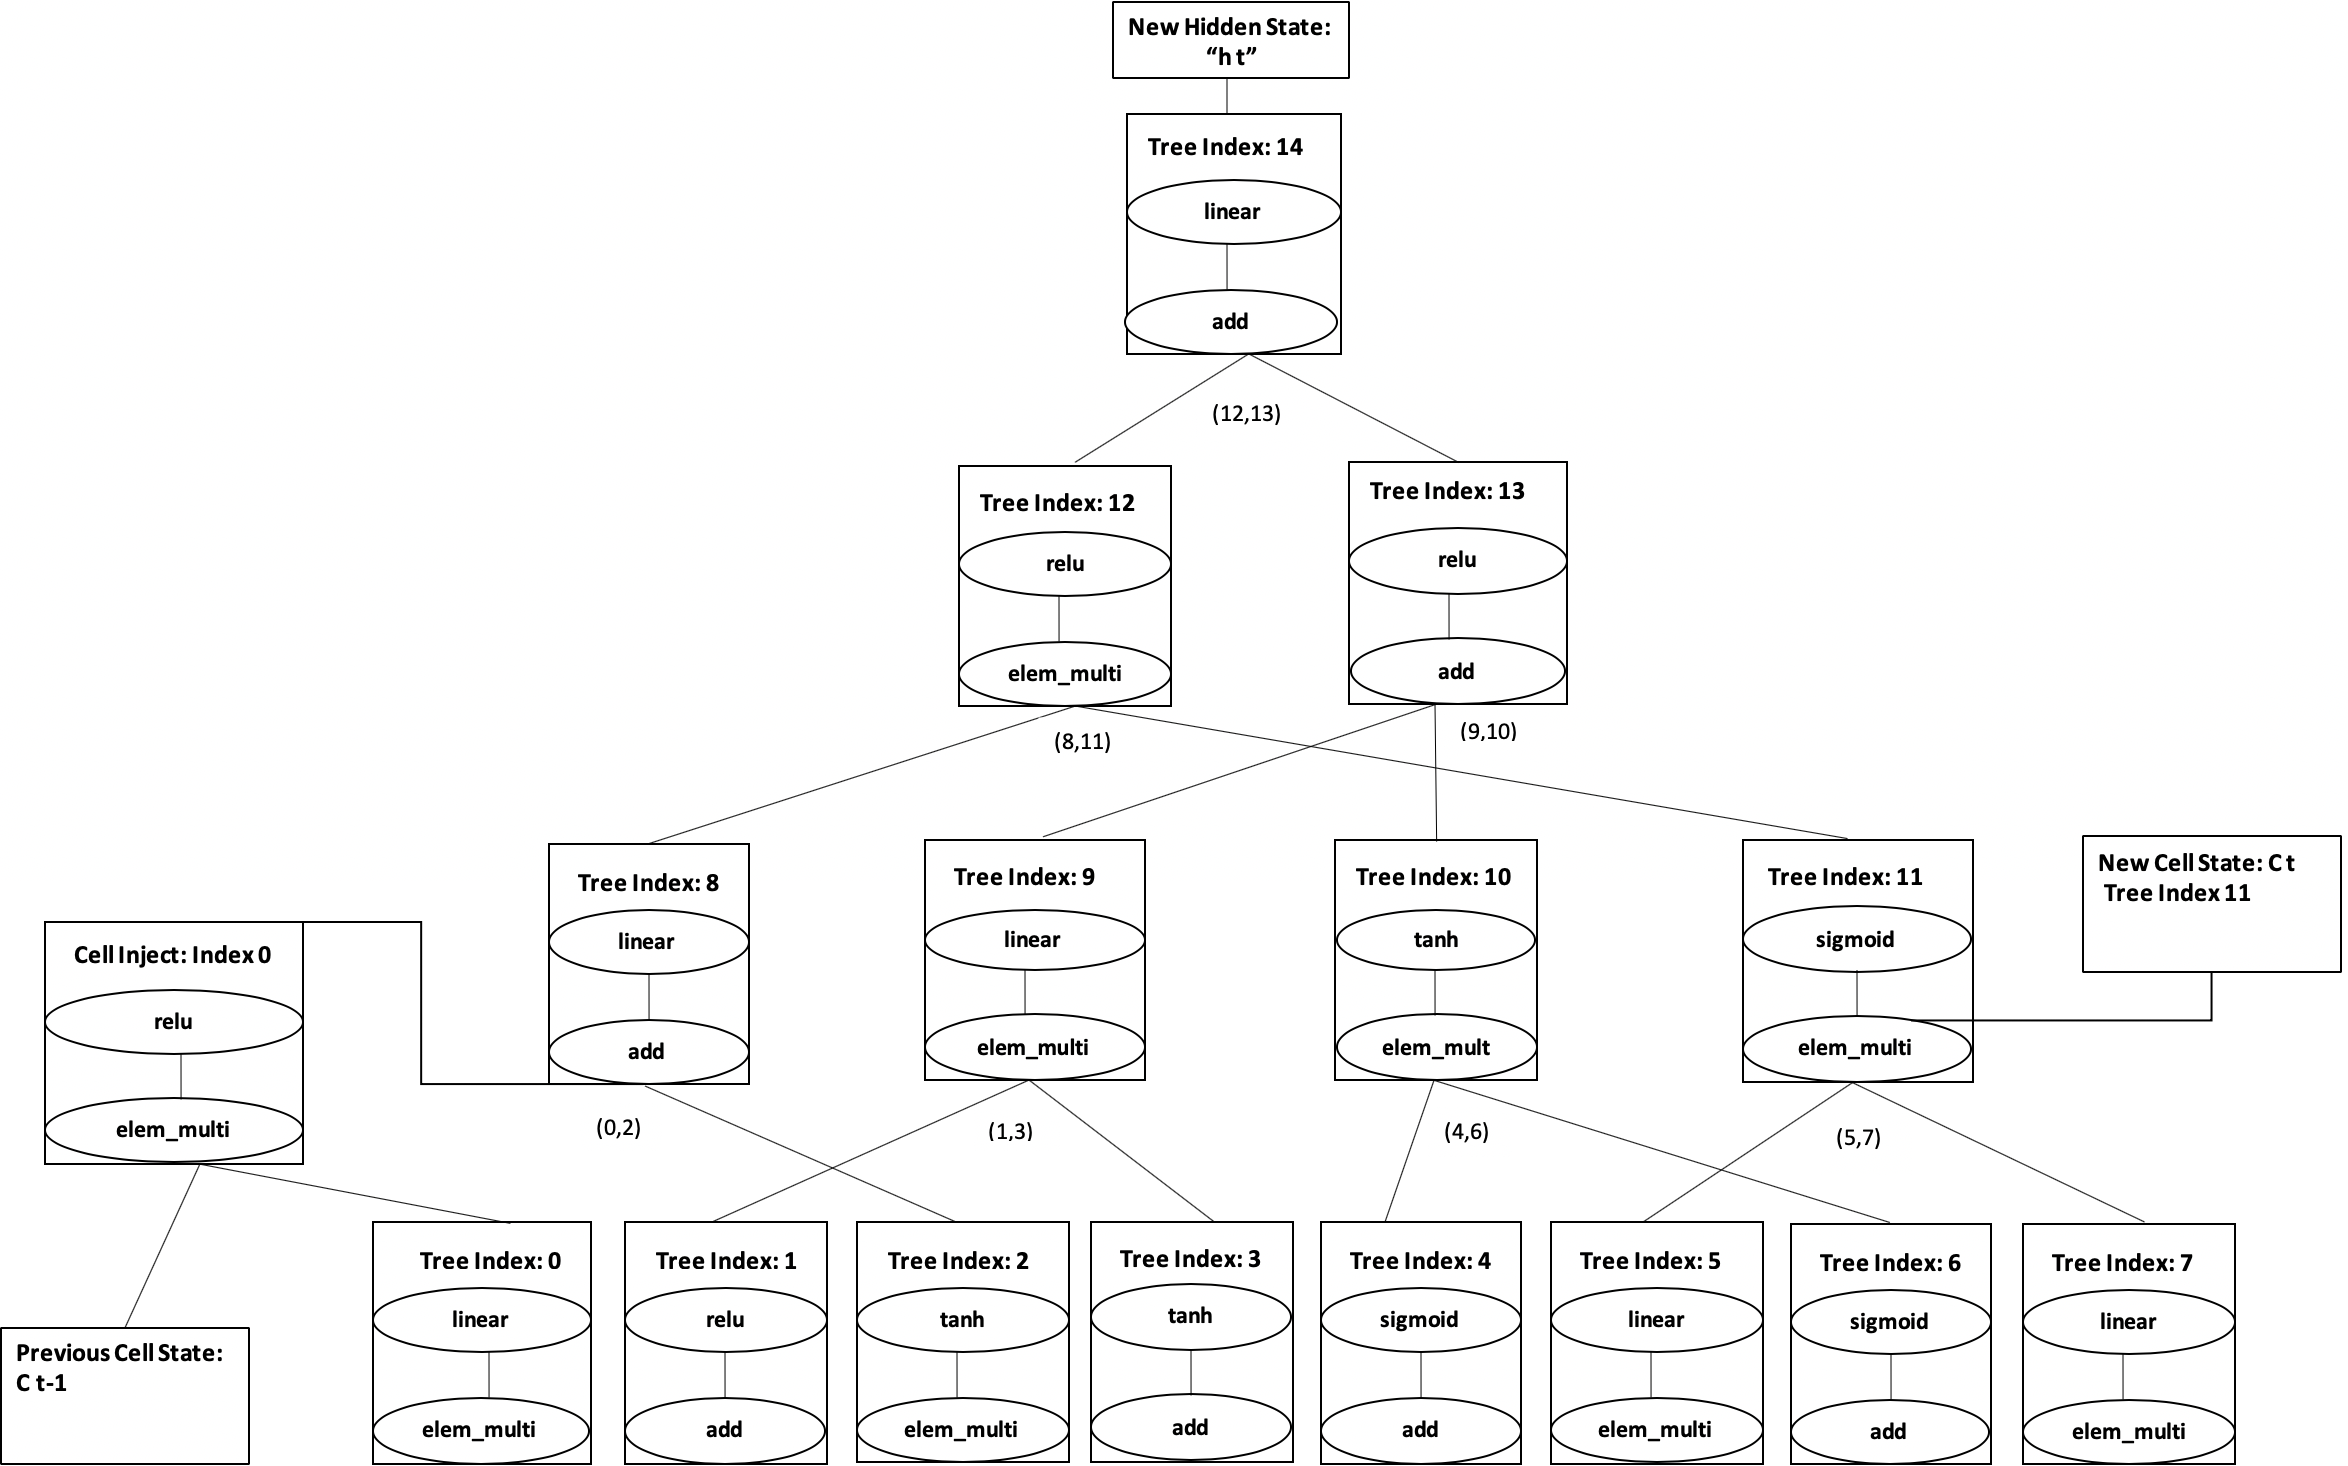

<img src="Jupyter_Notebook/custom_RNN_Cell.png" />

        - the Leaf Nodes (Tree Index 0 to 7):
          take as inputs the current state "x t" and the hidden state "h t-1"
          
        - the Cell Inject Node: overwrites the output of Tree Index 0
        
        - the new Cell State: taken from Tree Index 11 before the Activation Function is applied
        
        - Tree Index 8 to 13: intermediate Nodes
        
        - Tree Index 14: final Node

#### Function for building the RNN from the Hyperparameters sampled by Optuna:

In [ ]:
from keras.layers import Lambda,BatchNormalization
def build_custom_model(type_weights_regularizer,rl_value,
                      X_train,n_base,neurons_1,neurons_2,dropout_1,dropout_2,
                      optimizer,lr_value,
                      leaf_level_activations,leaf_level_actions,
                      index_cell_inject,action_cell_inject,activation_cell_inject,
                      index_new_cell_state,
                      intermediate_level_indexes,intermediate_level_activations,intermediate_level_actions,
                      final_level_indexes,final_level_activation,final_level_action,
                      clip_gradients,clipvalue=None):   
    
    if type_weights_regularizer=="L1":
        weights_regularizer=keras.regularizers.l1(rl_value)
    else:
        weights_regularizer=keras.regularizers.l2(rl_value)
    
    
    
    model=keras.models.Sequential()
    input_layer = keras.layers.InputLayer(input_shape=(X_train.shape[1:]))
    model.add(input_layer)
    

    #CREATE THE ACTUAL CUSTOM RNN CELL:
    custom_rnn_cell_1=Custom_RNNCell_tree(
                units=neurons_1,
                 base=n_base,
                 #Leaf Nodes:
                 activations_leaf_nodes=leaf_level_activations,
                 actions_leaf_nodes=leaf_level_actions,
                 #Cell Inject:
                 index_cell_inject=index_cell_inject,
                 action_cell_inject=action_cell_inject,
                 activation_cell_inject=activation_cell_inject,
                 #New Cell State:
                 index_new_cell_state=index_new_cell_state,
                 #Intermediate Levels (Internal Nodes):
                 index_intermediate_levels=intermediate_level_indexes,
                 activations_intermediate_levels=intermediate_level_activations,
                 actions_intermediate_levels=intermediate_level_actions,
                 #Final Node:
                 index_last_node=final_level_indexes,
                 activation_last_node=final_level_activation,
                 action_last_node=final_level_action,
                 kernel_regularizer=weights_regularizer,
                 recurrent_regularizer=weights_regularizer)
    
    rnn_layer_1=keras.layers.RNN(custom_rnn_cell_1,return_sequences=True)                               
        
    model.add(rnn_layer_1)
    
    #ADD DROPOUT IF >0.0:
    if dropout_1>0.0:
        model.add(Dropout(dropout_1))
    
    custom_rnn_cell_2=Custom_RNNCell_tree(
                units=neurons_2,
                 base=n_base,
                 #Leaf Nodes:
                 activations_leaf_nodes=leaf_level_activations,
                 actions_leaf_nodes=leaf_level_actions,
                 #Cell Inject:
                 index_cell_inject=index_cell_inject,
                 action_cell_inject=action_cell_inject,
                 activation_cell_inject=activation_cell_inject,
                 #New Cell State:
                 index_new_cell_state=index_new_cell_state,
                 #Intermediate Levels (Internal Nodes):
                 index_intermediate_levels=intermediate_level_indexes,
                 activations_intermediate_levels=intermediate_level_activations,
                 actions_intermediate_levels=intermediate_level_actions,
                 #Final Node:
                 index_last_node=final_level_indexes,
                 activation_last_node=final_level_activation,
                 action_last_node=final_level_action,
                 kernel_regularizer=weights_regularizer,
                 recurrent_regularizer=weights_regularizer)
    
    
    rnn_layer_2=keras.layers.RNN(custom_rnn_cell_2,return_sequences=False)                               
        
    model.add(rnn_layer_2)
    
    #ADD DROPOUT IF >0.0:
    if dropout_2>0.0:
        model.add(Dropout(dropout_2))
     
    
    
    model.add(Dense(1,activation="linear"))
    loss="mse"#rmse
    #OPTIMIZER:
    if optimizer=="adam":
        if clip_gradients==True:
            model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_value,clipvalue=clipvalue),
                      loss=loss)
        else:
            model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_value),
                      loss=loss)
                          
    else:# optimizer=="Adagrad":
        if clip_gradients==True:
            model.compile(optimizer=keras.optimizers.Adagrad(learning_rate=lr_value,clipvalue=clipvalue),
                      loss=loss)
        else: 
            model.compile(optimizer=keras.optimizers.Adagrad(learning_rate=lr_value),
                      loss=loss)
    return model

### 1.2.2. Objective Function for LSTM:
- **includes the same hyperparameters as the Objective Function for custom RNN-Cell**:<br>
        - except the ones for the NAS part (not relevant for LSTM-Cells)
        
        - aim: get a fair baseline model

        

In [60]:
import optuna
### import extra_keras_metrics
def objective_LSTM(trial): 
    seed(123)
    set_seed(123)
    
    print("SUMMARY CURRENT TRIAL: "+"\n")
    #SAMPLE FURTHER HYPERPARAMETERS: ###################################################################    
    dropout_1=trial.suggest_categorical('dropout_1', [0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5])
    dropout_2=trial.suggest_categorical('dropout_2', [0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5])
    
    neurons_1=trial.suggest_int('neurons_1', low=100, high=800, step=50)
    neurons_2=trial.suggest_int('neurons_2', low=100, high=800, step=50)

    type_weights_regularizer=trial.suggest_categorical('type_regularizer', ["L1","L2"])
    rl_value=trial.suggest_categorical('rl_value', 
                                           [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
                                           0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09,0.1])
    
    activation=trial.suggest_categorical('activation', ["relu","tanh"])
    
    epochs=trial.suggest_categorical('epochs', [100,150,200])
    
    batch_size=trial.suggest_categorical('batch_size', [32,64,128])
    
    window_size=trial.suggest_int('window_size', low=10, high=50, step=1)
    
    
    lr_value=trial.suggest_discrete_uniform('lr_value', 0.001,0.01,0.001)
    lr_value=round(lr_value,5)
    #clipvalue=trial.suggest_categorical('clipvalue',[1.0,1.5,2.0])#,1.0,1.5,2.0])
    ####################################################################################################
    
    #Currently fix hyperparameters:
    num_layers=2#fixed!
    optimizer="adam"
    callbacks_patience=10
    early_stop=EarlyStopping(monitor='val_loss', mode='min',min_delta=0.01, 
                             verbose=0, patience=callbacks_patience, 
                             restore_best_weights=True)
    callbacks=[early_stop]
    train_test_split=0.7
    
    #PRINT OUT SUMMARY OF SAMPLED HYPERPARAMETERS TO KEEP TRACK OF THE OPTIMIZATION: ###################
    print("2. FURTHER HYPERPARAMETERS:"+"\n")
    print("  2.1. UNCONDITIONAL:"+"\n")
    print("     - Window Size Sequences: "+str(window_size))
    print("     - Sequential Split: first "+str(train_test_split*100)+"% train set, the rest "+str(round((1-train_test_split),2)*100)+"% test set")
    print("     - Number Layers: "+str(num_layers))
    print("     - Number Neurons 1. Layer: "+str(neurons_1))
    print("     - Number Neurons 2. Layer: "+str(neurons_2))
    
    #print("  - Activation Function: "+activation)
    print("     - Dropout after 1. Layer: "+str(dropout_1))
    print("     - Dropout before final Dense Layer: "+str(dropout_2))
    print("     - Batch Size: "+str(batch_size))
    print("     - Epochs: "+str(epochs))
    print("     - Callbacks (Patience): "+str(callbacks_patience))
    print("     - Optimizer: "+optimizer)
    print("     - Learning Rate Value: "+str(lr_value))
    print("     - Type Regularization: "+type_weights_regularizer)
    print("     - Decay for Regularization: "+str(rl_value)+"\n")   
    
     
    ###################################################################################################        
    #DATA PREPROCESSING: ###############################################################################
    relevant_data=fBm_synthetic_data.copy()#synthetic_data[0].copy()
    X_sequences, y_sequences=split_sequence_univariate(relevant_data.values, window_size)
    X_sequences=X_sequences.reshape(X_sequences.shape[0],X_sequences.shape[1],1)
    y_sequences=y_sequences.reshape(y_sequences.shape[0],1)
    train_size=train_size=int(train_test_split*len(X_sequences))
    X_train, X_test =X_sequences[:train_size],X_sequences[train_size:]
    y_train,y_test=y_sequences[:train_size],y_sequences[train_size:]
    ####################################################################################################
    
    
    #BUILD AND TRAIN THE RNN-MODEL WITH THE SAMPLED HYPERPARAMETERS: #################    
    #USE WHEN TESTING BASELINE MODEL: LSTM: #############################################################
    
    if type_weights_regularizer=="L1":
        weights_regularizer=keras.regularizers.l1(rl_value)
    else:
        weights_regularizer=keras.regularizers.l2(rl_value)
    
    model=keras.models.Sequential()
    input_layer = keras.layers.InputLayer(input_shape=(X_train.shape[1:]))
    model.add(input_layer)
                               
        
    model.add(keras.layers.LSTM(units=neurons_1,activation=activation,return_sequences=True,
                                kernel_regularizer=weights_regularizer,
                                recurrent_regularizer=weights_regularizer))
    
    #ADD DROPOUT IF >0.0:
    if dropout_1>0.0:
        model.add(Dropout(dropout_1))
    
    model.add(keras.layers.LSTM(units=neurons_2,activation=activation,return_sequences=False,
                                kernel_regularizer=weights_regularizer,
                                recurrent_regularizer=weights_regularizer))
    #ADD DROPOUT IF >0.0:
    if dropout_2>0.0:
        model.add(Dropout(dropout_2))
     
    
    
    model.add(Dense(1,activation="linear"))
    loss="mse"#rmse
    clip_gradients=False
    #OPTIMIZER:
    if optimizer=="adam":
        if clip_gradients==True:
            model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_value,clipvalue=clipvalue),
                      loss=loss)
        else:
            model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_value),
                      loss=loss)
                          
    else:# optimizer=="Adagrad":
        if clip_gradients==True:
            model.compile(optimizer=keras.optimizers.Adagrad(learning_rate=lr_value,clipvalue=clipvalue),
                      loss=loss)
        else: 
            model.compile(optimizer=keras.optimizers.Adagrad(learning_rate=lr_value),
                      loss=loss)
    ####################################################################################################
    
    
    print("3. KERAS ARCHITECTURE SUMMARY:")
    print(model.summary())
    
    #TRY FITTING THE SAMPLED RNN-MODEL:
    try:
        history_fitted_model=model.fit(X_train, y_train, 
                                   epochs=epochs, batch_size=batch_size, 
                                   validation_data=[X_test,y_test],verbose=1,
                                   callbacks=callbacks)
        output="no_nans"
    except TypeError:
        output="nans" 
    ####################################################################################################
    
    
    #GENERATE PREDICTIONS, REVERSE THE SCALE AND COMPUTE MAPE: #########################################
    if output=="no_nans":
        print("4. KERAS TRAIN-TEST LOSS-PLOT:")
        keras_plot(history_fitted_model)
        predictions=model.predict(X_test,verbose=0)
    
        y_test=y_test.reshape(y_test.shape[0])
        predictions=predictions.reshape(predictions.shape[0])
        mape=compute_mape(y_test,predictions)
        mape=round(mape,5)
    
        print("5. MAPE CURRENT TRIAL: "+str(mape))
        print(""+"\n")

        print("6. PLOT PREDICTIONS VS. TRUE VALUES:")
        plt.figure(figsize=(15,10))
        plt.plot(predictions)
        plt.plot(y_test)
    
        plt.title('PREDICTIONS VS. TRUE')
        plt.legend(['Predictions', 'True'], loc='upper left')
        plt.show()
        print(""+"\n")
    else:
        mape=np.float("nan")
    
    ####################################################################################################
    
    
    return mape

## 2. Further Functions: 

### 2.1. Splitting the Data into Sequences: Univariate

In [61]:
#Sequence-Splitting for univariate Timeseries:
def split_sequence_univariate(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
         #gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

### 2.2. Keras Plot Train vs. Test History: 

In [62]:
def keras_plot(history):
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

### 2.3. Compute Mean-Absolute-Percentage-Error (MAPE) for the Predictions & the True Values:
- MAPE used as the evaluation metric in the Optuna-Trials

In [ ]:
def compute_mape(y_original_reversed,y_predictions_reversed):
    mape=np.array(abs((y_original_reversed-y_predictions_reversed)/y_original_reversed)).mean()*100
    return mape

## 3. Data Retrieval

### 3.1. Synthetic Data

        

### 3.1.1. Simulating Fractional Brownian Motion:

- **Method of Cholesky**:
        - create a sequence of numbers
        
        - compute the kernel matrix of a standard Fractional Brownian Motion
        
        - apply Cholesky Decomposition
        
        - if N=number of samples to be simulated, sample N-1 values from the 
          standard Gaussian distribution 
          
        - compute the product of the transposed decomposed matrix and the N-1 standard Gaussian samples
        
        - Source: 
        Simulation and Identification of the Franctional Brownian Motion: A bibliographical and comparative study 
        (Concept: p. 7-8, Code example: p. 29 in Appendix A.3)

In [ ]:
# Link to the Source: https://scholar.google.com/scholar?hl=en&as_sdt=0%2C5&q=SIMULATION+AND+IDENTIFICATION+OF+THE+FRACTIONAL+BROWNIAN+MOTION%3A+A+BIBLIOGRAPHICAL+AND+COMPARATIVE+STUDY&btnG=

          x
0  0.000000
1  0.005228
2  0.015765
3  0.017793
4  0.022557


Text(0.5, 0, 'Time')

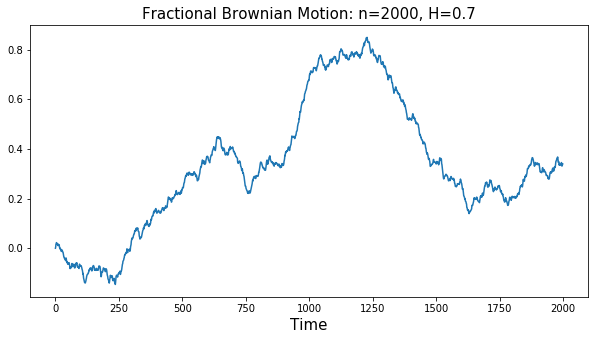

In [54]:
fBm_synthetic_data = pd.read_csv(r"/Users/i530967/desktop/fmB_data_simulted.csv", sep=',',header=0)
print(fBm_synthetic_data.head())
plt.figure(figsize=(10,5))
plt.plot(fBm_synthetic_data)
plt.title('Fractional Brownian Motion: n=2000, H=0.7',fontsize=15)
#plt.ylabel('Fractional Brownian Motion',fontsize=15)
plt.xlabel('Time',fontsize=15)


### 3.1.2. Simulating Time Series with R-Package GRATIS:

- **Link to Github-Repository**: https://github.com/ykang/gratis/blob/master/man/generate_ts_with_target.Rd

- **Link to Paper**: https://arxiv.org/pdf/1903.02787.pdf


- **The Package supports Simulating Time Series with controllable Features**

- **For Example, by using the function "generate_ts_with_target()" we can specify**:
        - freq = Frequency of the Time Series
        
        - seasonal: 0 for non-seasonal data, 
          1 for single-seasonal data, 
          and 2 for multiple seasonal data
          
        - features = which feature-function to control, 
          for example entropy & stl features
          
        - selected.features = for example for stl_features: trend
        
        - target = the desired values for the features

          x
0  1.387153
1 -0.100260
2 -1.422987
3  0.494772
4  0.670056


Text(0.5, 0, 'Time')

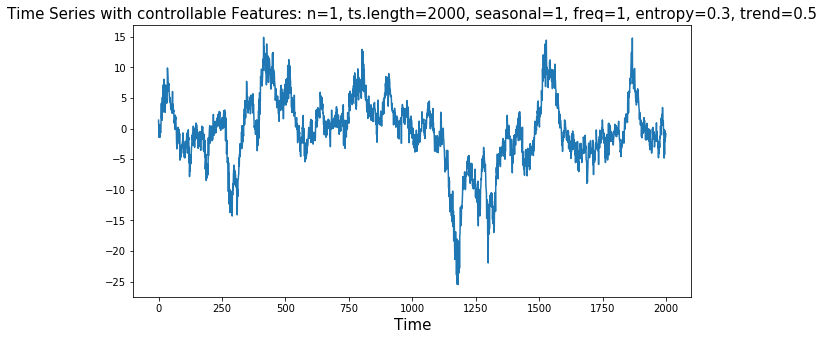

In [55]:
ts_with_target = pd.read_csv(r"/Users/i530967/desktop/ts_with_target.csv", sep=',',header=0)
print(ts_with_target.head())
plt.figure(figsize=(10,5))
plt.plot(ts_with_target)
plt.title('Time Series with controllable Features: n=1, ts.length=2000, seasonal=1, freq=1, entropy=0.3, trend=0.5',fontsize=15)
plt.xlabel('Time',fontsize=15)

### 3.1.3. Simulating a Gaussian Process:
- **Simulating a Gaussian Process (GP) involves**:
        - 1. Step: generate (ordered) sequence of numbers x={x1,x2,...x n}
        
        - 2. Step: generate covariance matrix K(x,x) by applying a particular kernel function k
                   to each pair of points from the sequence x
        
        - 3. Step: generate synthetic time series by passing the covariance matrix & mean vector
                   of zeros to numpy.random.multivariate_normal
                   
        - 4. Step (Optinal): generate (for example) white noise & add it to the synthetic time series
                             (White Noise Kernel: k(x,x)= σ^2 x Identity Matrix) 
<br>        
- **Kernel Function for Local Periodic Signal**: <br> <br>
    combines Squarred Exponential Kernel & Exp-Sine-Squared (Periodic) kernel
                   
                   

In [ ]:
import tensorflow.compat.v1 as tf
import tensorflow_probability as tfp
tf_distributions = tfp.distributions
tf_kernels = tfp.math.psd_kernels

#Source: https://peterroelants.github.io/posts/gaussian-process-kernels/

def combined_covariance(periodic_amplitude, periodic_length_scale,exponential_quadratic_length_scale,
                        period, sequence):
    """Local Periodic Kernel: combines Squarred Exponential Kernel & Exp-Sine-Squared (Periodic) kernel"""
    #Amplitude: used for only for the periodic kernel:
    periodic_amplitude_tf = tf.constant(periodic_amplitude, dtype=tf.float64)
    exponential_quadratic_amplitude_tf=1#always!
    
    #Length Scale for each of the kernels:
    periodic_length_scale_tf = tf.constant(periodic_length_scale, dtype=tf.float64)# (Periodic Kernel)
    exponential_quadratic_length_scale_tf = tf.constant(exponential_quadratic_length_scale, dtype=tf.float64)# (Exp-Quadratic Kernel)
    
    #Period: used only for the periodic kernel:
    period_tf = tf.constant(period, dtype=tf.float64)
    
    combined_kernel=(
    #Periodic Kernel: exp-sine-squared kernel
    tf_kernels.ExpSinSquared(
            amplitude=periodic_amplitude_tf, 
            length_scale=periodic_length_scale_tf,
            period=period_tf) * 
    #Exponential Quadratic Kernel:
    tf_kernels.ExponentiatedQuadratic(
            length_scale=exponential_quadratic_length_scale_tf,
            amplitude=exponential_quadratic_amplitude_tf))
    
    #Generate the Covariance Matrix:
    kernel_matrix = combined_kernel.matrix(sequence, sequence)
    kernel_matrix_readable=K.eval(kernel_matrix)
    
    return kernel_matrix_readable


In [ ]:
def white_noise(std,num_samples):
    var_noise=std**2
    cov_matrix=var_noise*np.eye(num_samples)
    y = np.random.multivariate_normal(
        mean=np.zeros(num_samples), cov=cov_matrix, 
        size=1)[0]
    return y

Text(0.5, 0, 'Time')

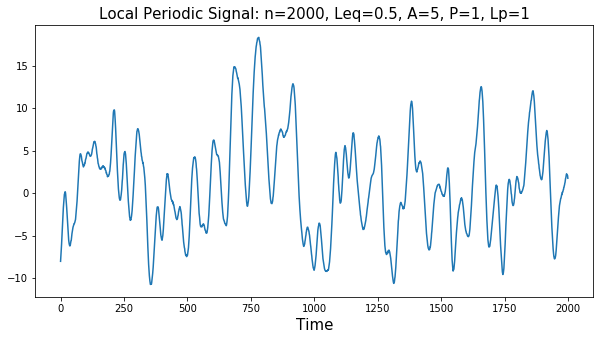

In [56]:
seed(123)
number_samples=2000
#Start and End Point can be manipulated:
start_point=-10
end_point=10
ordered_sequence=np.expand_dims(np.linspace(start_point,end_point, number_samples),1)

#Amplitude = Variance
amplitude=5

#Length Scale EQ-Kernel = the length of the 'wiggles' in the function
length_scale_eq=0.5

#Period in Periodic-Kernel: the distnace between the repititions
period=1

#Length Scale Periodic-Kernel: the same as in EQ-Kernel
length_scale_periodic=1

mean_vector=np.zeros(number_samples)


kernel_matrix_combined = combined_covariance(periodic_amplitude=amplitude,
                                             periodic_length_scale=length_scale_periodic,
                                             exponential_quadratic_length_scale=length_scale_eq,
                                             period=period, sequence=ordered_sequence)

synthetic_time_series_combined_kernel= np.random.multivariate_normal(
    mean=mean_vector, cov=kernel_matrix_combined, 
    size=1)[0]

noise=white_noise(std=0.05,num_samples=2000)

synthetic_time_series_combined_kernel=synthetic_time_series_combined_kernel+noise
synthetic_time_series_combined_kernel=pd.DataFrame({"Local_Periodic_Signal":synthetic_time_series_combined_kernel},
                                                  columns=["Local_Periodic_Signal"])
plt.figure(figsize=(10,5))
plt.plot(synthetic_time_series_combined_kernel)
plt.title('Local Periodic Signal: n=2000, Leq=0.5, A=5, P=1, Lp=1',fontsize=15)
#plt.ylabel('Local Periodic Signal',fontsize=15)
plt.xlabel('Time',fontsize=15)

## 4. NAS
- **Number of hidden Layers**: 
        - currently fixed to 2 (for both LSTMs and custom RNN-Cells)
        
        - advised so in the paper "Neural Architecture Search with Reinforcement Learning"
<br>

- **The Seed for Numpy and Tensorflow**:
        - set to a pre-specified value during the trials with Optuna in order to ensure reproducibility of the results
        
        - results obtained from the same models ran with the same hyperparameters will still vary a little bit 
          (due to the backend used, whether CPU or GPU is used etc.), but less compared to not setting the seeds
          
        - once optimal hyperparameters exracted from the trials with Optuna: test different seeds
          in order to test for consistency of the results when randomization is introduced

### 4.1. Fractional Brownian Motion

### A) Baseline Model: LSTM

#### Run 50 Trials with Optuna

In [ ]:
#Seeds set in the functions:
study = optuna.create_study()
study.optimize(objective_LSTM, n_trials=50)

In [64]:
best_params=study.best_trial.params
print("Best Params LSTM for Brownian Motion Signal: ")
print(best_params)

Best Params LSTM for Brownian Motion Signal: 
{'dropout_1': 0.05, 'dropout_2': 0.45, 'neurons_1': 300, 'neurons_2': 800, 'type_regularizer': 'L2', 'rl_value': 0.002, 'activation': 'tanh', 'epochs': 150, 'batch_size': 64, 'window_size': 37, 'lr_value': 0.002}


#### Results from 1 Run with the optimal Hyperparameters with a pre-specified seed:

In [ ]:
seed(123)
set_seed(123)

X_sequences, y_sequences=split_sequence_univariate(fBm_synthetic_data.values, 37)
train_size=train_size=int(0.7*len(X_sequences))
X_train, X_test =X_sequences[:train_size],X_sequences[train_size:]
y_train,y_test=y_sequences[:train_size],y_sequences[train_size:]

model=keras.models.Sequential()
input_layer = keras.layers.InputLayer(input_shape=(X_train.shape[1:]))
model.add(input_layer)
model.add(keras.layers.LSTM(units=300,activation="tanh",return_sequences=True,
                                kernel_regularizer=keras.regularizers.l2(0.002),
                                recurrent_regularizer=keras.regularizers.l2(0.002)))
model.add(Dropout(0.05))
model.add(keras.layers.LSTM(units=800,activation="tanh",return_sequences=False,
                                kernel_regularizer=keras.regularizers.l2(0.002),
                                recurrent_regularizer=keras.regularizers.l2(0.002)))
model.add(Dropout(0.45))
model.add(Dense(1,activation="linear"))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.002),
                      loss="mse")
    #print(model.summary())
early_stop=EarlyStopping(monitor='val_loss', mode='min',min_delta=0.01, 
                             verbose=0, patience=10, 
                             restore_best_weights=True)
history_fitted_model=model.fit(X_train, y_train, 
                                   epochs=150, batch_size=64, 
                                   validation_data=[X_test,y_test],verbose=1,
                                   callbacks=[early_stop])
predictions=model.predict(X_test,verbose=0)
    
y_test=y_test.reshape(y_test.shape[0])
predictions=predictions.reshape(predictions.shape[0])
mape=compute_mape(y_test,predictions)
mape=round(mape,5)

Train vs. Test Loss:


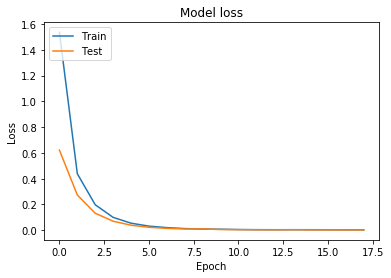

MAPE LSTM from 1 Run with optimal Hyperparameters & pre-specified seed:  7.28421


In [127]:
print("Train vs. Test Loss:")
keras_plot(history_fitted_model)
print("MAPE LSTM from 1 Run with optimal Hyperparameters & pre-specified seed: ",mape)

#### Average Results from 10 Runs with the optimal Hyperparameters with different seeds:

In [ ]:
seed(123)
seeds_to_test=np.random.randint(low=1,high=1000,size=10)

In [ ]:
X_sequences, y_sequences=split_sequence_univariate(fBm_synthetic_data.values, 37)
train_size=train_size=int(0.7*len(X_sequences))
X_train, X_test =X_sequences[:train_size],X_sequences[train_size:]
y_train,y_test=y_sequences[:train_size],y_sequences[train_size:]

mape_results=[]
models=[]
history_fitted_models=[]
for i in range(0,10):
    seed(seeds_to_test[i])
    set_seed(seeds_to_test[i])

    print(i)
    model=keras.models.Sequential()
    input_layer = keras.layers.InputLayer(input_shape=(X_train.shape[1:]))
    model.add(input_layer)
    model.add(keras.layers.LSTM(units=300,activation="tanh",return_sequences=True,
                                kernel_regularizer=keras.regularizers.l2(0.002),
                                recurrent_regularizer=keras.regularizers.l2(0.002)))
    model.add(Dropout(0.05))
    model.add(keras.layers.LSTM(units=800,activation="tanh",return_sequences=False,
                                kernel_regularizer=keras.regularizers.l2(0.002),
                                recurrent_regularizer=keras.regularizers.l2(0.002)))
    model.add(Dropout(0.45))
    model.add(Dense(1,activation="linear"))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.002),
                      loss="mse")
    #print(model.summary())
    early_stop=EarlyStopping(monitor='val_loss', mode='min',min_delta=0.01, 
                             verbose=0, patience=10, 
                             restore_best_weights=True)
    history_fitted_model=model.fit(X_train, y_train, 
                                   epochs=150, batch_size=64, 
                                   validation_data=[X_test,y_test],verbose=1,
                                   callbacks=[early_stop])
    predictions=model.predict(X_test,verbose=0)
    
    y_test=y_test.reshape(y_test.shape[0])
    predictions=predictions.reshape(predictions.shape[0])
    mape=compute_mape(y_test,predictions)
    mape=round(mape,5)
    print("Mape LSTM: ",mape)
    
    mape_results.append(mape)
    models.append(model)
    history_fitted_models.append(history_fitted_model)

#### Average Performance of the 10 Runs:

In [146]:
print("Average MAPE from 10 Runs (best LSTM) on Fractional Brownian Motion Signal when varying the seed: ",round(np.mean(mape_results),3))



Average MAPE from 10 Runs (best LSTM) on Fractional Brownian Motion Signal when varying the seed:  6.73


#### Best Performance within the 10 Runs: minimal MAPE

Minimal MAPE achieved within the 10 Runs:  5.492
Training History of the Model that achieved minimal MAPE within the 10 Runs: 


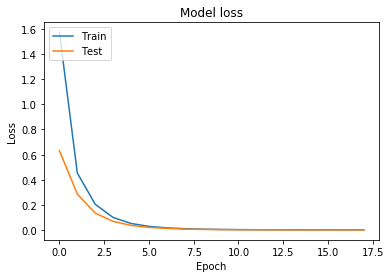

In [147]:
print("Minimal MAPE achieved within the 10 Runs: ",round(np.min(mape_results),3))
index_best_model=np.where(mape_results==np.min(mape_results))[0][0]
best_model=models[index_best_model]
best_history=history_fitted_models[index_best_model]
print("Training History of the Model that achieved minimal MAPE within the 10 Runs: ")
keras_plot(best_history)
#best seed for LSTM: 989

### B) RNN-Cell structured as a Tree

#### Run 50 Trials with Optuna

In [ ]:
#Seeds set in the function:
study = optuna.create_study()
study.optimize(objective_RNN_Tree, n_trials=50)

#### Results from 1 Run with the optimal Hyperparameters with a pre-specified seed:

In [ ]:
#Set the random Set of Numpy and Tensorflow in order to get reproducible results:
seed(123)
set_seed(123)


X_sequences, y_sequences=split_sequence_univariate(fBm_synthetic_data.values, 35)
train_size=train_size=int(0.7*len(X_sequences))
X_train, X_test =X_sequences[:train_size],X_sequences[train_size:]
y_train,y_test=y_sequences[:train_size],y_sequences[train_size:]


#Build the optimal Model using further optimal Hyperparameters sampled by Optuna:

model=build_custom_model(type_weights_regularizer="L2",rl_value=0.003,
        X_train=X_train,
        n_base=8,
        neurons_1=550,
        neurons_2=300,
        dropout_1=0.05,
        dropout_2=0.3,
        optimizer="adam",
        lr_value=0.003,
        leaf_level_activations=['tanh', 'relu', 'linear', 'sigmoid', 'tanh', 'tanh', 'tanh', 'linear'],
        leaf_level_actions=['elem_multi', 'elem_multi', 'elem_multi', 'add', 'add', 'elem_multi', 'elem_multi', 'elem_multi'],
        index_cell_inject=2,
        action_cell_inject="add",
        activation_cell_inject="relu",
        index_new_cell_state=9,
        intermediate_level_indexes=[[0, 6], [1, 4], [2, 7], [3, 5], [8, 11], [9, 10]],
        intermediate_level_activations=['relu', 'tanh', 'tanh', 'relu', 'sigmoid', 'linear'],
        intermediate_level_actions=['elem_multi', 'add', 'elem_multi', 'elem_multi', 'add', 'add'],
        final_level_indexes=[13, 12],
        final_level_activation="linear",
        final_level_action="elem_multi",
        clip_gradients=False,
        clipvalue=None)

#print(model.summary())
early_stop=EarlyStopping(monitor='val_loss', mode='min',min_delta=0.01, 
                             verbose=0, patience=10, 
                             restore_best_weights=True)
history_fitted_model=model.fit(X_train, y_train, 
                                   epochs=150, batch_size=32, 
                                   validation_data=[X_test,y_test],verbose=0,
                                   callbacks=[early_stop])

predictions=model.predict(X_test,verbose=0)
    
y_test=y_test.reshape(y_test.shape[0])
predictions=predictions.reshape(predictions.shape[0])
mape=compute_mape(y_test,predictions)
mape=round(mape,5)

Train vs. Test Loss:


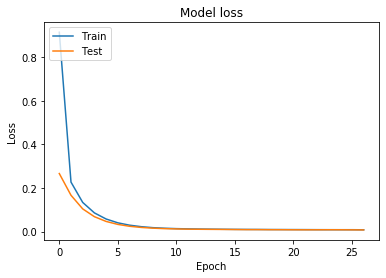

MAPE custom RNN-Cell from 1 Run with optimal Hyperparameters & pre-specified seed:  2.35266


In [108]:
print("Train vs. Test Loss:")
keras_plot(history_fitted_model)
print("MAPE custom RNN-Cell from 1 Run with optimal Hyperparameters & pre-specified seed: ",mape)

#### Average Results from 10 Runs with the optimal Hyperparameters with different seeds:

In [ ]:
X_sequences, y_sequences=split_sequence_univariate(fBm_synthetic_data.values, 35)
train_size=train_size=int(0.7*len(X_sequences))
X_train, X_test =X_sequences[:train_size],X_sequences[train_size:]
y_train,y_test=y_sequences[:train_size],y_sequences[train_size:]


#Build the optimal Model using further optimal Hyperparameters sampled by Optuna:
mape_results=[]
models=[]
history_fitted_models=[]
for i in range(0,10):
    seed(seeds_to_test[i])
    set_seed(seeds_to_test[i])
    
    model=build_custom_model(type_weights_regularizer="L2",rl_value=0.003,
        X_train=X_train,
        n_base=8,
        neurons_1=550,
        neurons_2=300,
        dropout_1=0.05,
        dropout_2=0.3,
        optimizer="adam",
        lr_value=0.003,
        leaf_level_activations=['tanh', 'relu', 'linear', 'sigmoid', 'tanh', 'tanh', 'tanh', 'linear'],
        leaf_level_actions=['elem_multi', 'elem_multi', 'elem_multi', 'add', 'add', 'elem_multi', 'elem_multi', 'elem_multi'],
        index_cell_inject=2,
        action_cell_inject="add",
        activation_cell_inject="relu",
        index_new_cell_state=9,
        intermediate_level_indexes=[[0, 6], [1, 4], [2, 7], [3, 5], [8, 11], [9, 10]],
        intermediate_level_activations=['relu', 'tanh', 'tanh', 'relu', 'sigmoid', 'linear'],
        intermediate_level_actions=['elem_multi', 'add', 'elem_multi', 'elem_multi', 'add', 'add'],
        final_level_indexes=[13, 12],
        final_level_activation="linear",
        final_level_action="elem_multi",
        clip_gradients=False,
        clipvalue=None)

    #print(model.summary())
    early_stop=EarlyStopping(monitor='val_loss', mode='min',min_delta=0.01, 
                             verbose=0, patience=10, 
                             restore_best_weights=True)
    history_fitted_model=model.fit(X_train, y_train, 
                                   epochs=150, batch_size=32, 
                                   validation_data=[X_test,y_test],verbose=1,
                                   callbacks=[early_stop])
    keras_plot(history_fitted_model)
    predictions=model.predict(X_test,verbose=0)
    
    y_test=y_test.reshape(y_test.shape[0])
    predictions=predictions.reshape(predictions.shape[0])
    mape=compute_mape(y_test,predictions)
    mape=round(mape,5)
    print("MAPE custom RNN-Cell: ",mape)
    
    mape_results.append(mape)
    models.append(model)
    history_fitted_models.append(history_fitted_model)
    
    


#### Average Performance of the 10 Runs:

In [150]:
print("Average MAPE from 10 Runs (best custom RNN-Cell) on Fractional Brownian Motion Signal when varying the seed: ",round(np.mean(mape_results),3))


Average MAPE from 10 Runs (best custom RNN-Cell) on Fractional Brownian Motion Signal when varying the seed:  4.837


#### Best Performance within the 10 Runs: minimal MAPE

Minimal MAPE achieved within the 10 Runs:  2.75
Training History of the Model that achieved minimal MAPE within the 10 Runs: 


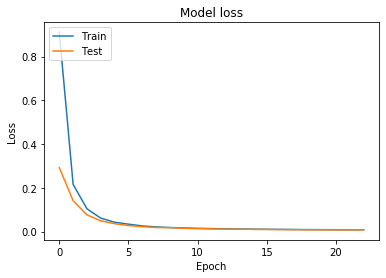

In [151]:
print("Minimal MAPE achieved within the 10 Runs: ",round(np.min(mape_results),3))
index_best_model=np.where(mape_results==np.min(mape_results))[0][0]
best_model=models[index_best_model]
best_history=history_fitted_models[index_best_model]
print("Training History of the Model that achieved minimal MAPE within the 10 Runs: ")
keras_plot(best_history)
#best seed for custom RNN-Cell: 123

### Summary of the Results:

- **The optimal Hyperparameters sampled by Optuna from the 50 Trials**:

    1) Window Size / Length of Sequence: 
        - LSTM: 37
        - custom RNN-Cell: 35
        
    2) Neurons in each layer: 
        - LSTM: neurons 1. layer 300 < neurons 2. layer 800
        - custom RNN-Cell: neurons 1. layer 550 > neurons 2.layer 300
        
    3) Dropout Layers (DP):
        - LSTM: DP rate after 1. hidden layer 0.05 < DP rate after 2. hidden layer 0.45
        - custom RNN-Cell: DP rate after 1. hidden layer 0.05 < DP rate after 2. hidden layer 0.3
    
    4) Weights Regularization:
        - LSTM: L2 with 0.002 decay
        - custom RNN-Cell: L2 with 0.003 decay
        
    5) Learning Rate: 
        - LSTM: 0.002
        - custom RNN-Cell: 0.003
    
    6) Batch Size:
        - LSTM: 64
        - custom RNN-Cell: 32
<br>

- **Comparison of the Results with a pre-specified seed and with random/different seeds:**
        - LSTM: better performance achieved when different seeds tested
        
        - custom RNN-Cell: no improvement in the performance when different seeds tested
        
        - average performance of the models from the 10 runs: 
          custom RNN-Cell MAPE 4.837 < LSTM MAPE 6.73
          
        - best performance of each of the models: minimal MAPE achieved
          custom RNN-Cell MAPE 2.35266 < LSTM MAPE 5.492

<br>

- **Conclusion from the Results so far:**
        - tuned custom RNN-Cell performs better than tuned LSTM
        
        - further experiments to be performed in the following way:
          set a seed during the trials with Optuna &
          once optimal hyperparameters extracted, vary the seed in order
          ensure consistent results even when randomization is introduced
          

    
    
        
    